<a href="https://colab.research.google.com/github/delhian/cv_course/blob/main/Home%20Tasks/object_detection_home_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Мы с вами на предыдущем уроке посмотрели несколько популярных репозиториев и разобрались, как обучить детектор на своем датасете.

Чтобы закрепить знания предлагается следующая задача:
На kaggle есть датасет для детекции лиц с медицинскими масками (ссылка на [датасет](https://www.kaggle.com/andrewmvd/face-mask-detection)). 
Для вашего удобства, чтобы не качать датасет вручную и не загружать на collab я его загрузил на гугл диск и скачать его можно при помощи следующей команды:


In [1]:
!gdown "https://drive.google.com/uc?export=download&id=1S48rk9zewPDdlH6NdBQKfFlK9AfIHK9x" 2> /dev/null

Далее его можно разархивировать при помощи следующей команды:

In [2]:
!unzip -qq FaceMaskDetection.zip -d FaceMaskDetection 2> /dev/null

После этого в дириктории `content` должно появиться следующее:

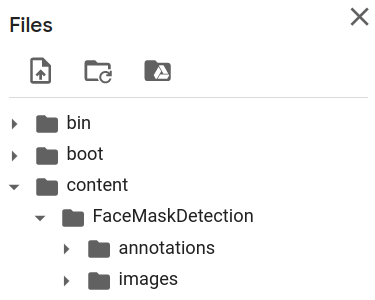

YOLO

In [3]:
!pip3 install opencv-python~=4.5.4 &> /dev/null
!pip3 install xmltodict &> /dev/null

In [4]:
%cd /content
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet  &> /dev/null

/content


In [5]:
%cd darknet

/content/darknet


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [7]:
!wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg  &> /dev/null
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights  &> /dev/null

In [8]:
# change makefile to have GPU and OPENCV enabled
# %cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [9]:
!make &> /dev/null

In [13]:
!rm -r /content/darknet/build/darknet/x64/data/images

rm: cannot remove '/content/darknet/build/darknet/x64/data/images': No such file or directory


In [14]:
import os
import cv2
import glob
import shutil
import xmltodict
from sklearn.model_selection import train_test_split

label_map = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}
SOURCE_PATH = '/content/FaceMaskDetection/images'
TARGET_PATH = '/content/darknet/build/darknet/x64/data/images'
shutil.copytree(SOURCE_PATH, TARGET_PATH)
list_of_images = glob.glob(TARGET_PATH  + "/*png")

list_of_train_images, list_of_test_images = train_test_split(list_of_images, test_size = 0.15)

with open(TARGET_PATH.replace('images', 'train.txt'), 'w') as f:
    for fname in list_of_train_images:
        f.write(f'{fname}\n')

with open(TARGET_PATH.replace('images', 'test.txt'), 'w') as f:
    for fname in list_of_test_images:
        f.write(f'{fname}\n')


for img in list_of_images:
  image = cv2.imread(img)
  h, w = image.shape[:2]

  annotation = SOURCE_PATH.replace('images', 'annotations/') + img.split('/')[-1]
  annotation = annotation.replace('png', 'xml')

  with open(annotation) as f:
    annotation_dict = xmltodict.parse(f.read())
  
  bboxes, labels = [], []
  objects = annotation_dict["annotation"]["object"]
  if not isinstance(objects, list):
    objects = [objects]
    
  with open(img.split('.')[0] + '.txt', 'w') as f:
    for obj in objects:
      bndbox = obj["bndbox"]
      bbox = [float(bndbox["xmin"]) / w, float(bndbox["ymin"]) / h, float(bndbox["xmax"]) / w, float(bndbox["ymax"]) / h]
      bbox = [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2, bbox[2] - bbox[0], bbox[3] - bbox[1]]
      label = label_map[obj["name"]]
      f.write(f'{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n')

Скачиваем веса:

In [15]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29  &> /dev/null
!mv yolov4-tiny.conv.29 build/darknet/x64 &> /dev/null

Скачиваем конфиг файл:

In [17]:
!wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg  &> /dev/null
!mv yolov4-tiny.cfg build/darknet/x64 &> /dev/null

In [26]:
less /content/darknet/build/darknet/x64/yolov4-tiny_masks.cfg

In [29]:
!./darknet detector train /content/darknet/build/darknet/x64/data/masks.data /content/darknet/build/darknet/x64/yolov4-tiny_masks.cfg /content/darknet/build/darknet/x64/yolov4-tiny.conv.29 -dont_show

Выходные данные были обрезаны до нескольких последних строк (5000).
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.835396), count: 13, class_loss = 0.579061, iou_loss = 9.828441, total_loss = 10.407502 
 total_bbox = 1326592, rewritten_bbox = 0.040781 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.526803), count: 1, class_loss = 0.568406, iou_loss = 0.004302, total_loss = 0.572708 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.835311), count: 7, class_loss = 0.170830, iou_loss = 7.670238, total_loss = 7.841068 
 total_bbox = 1326600, rewritten_bbox = 0.040781 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.926480), count: 2, class_loss = 0.000002, iou_loss = 0.130455, total_loss = 0.130457 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.869094), count: 9, class_loss = 0.090646, iou_loss = 12.527371, total_lo


Вам предлагается выбрать любой репозиторий для детекции объектов (или написать весь пайплайн самим) и обучить модель детектровать лица и определять, есть ли на них маска.  Всего в датасете 3 класса: 
- лицо без маски
- лицо в маске
- лицо с неправильно надетой маской

Последний класс при желании можете считать за лицо без маски, так как таких озображений достаточно мало плюс они не очень сильно отличаются от лица без маски. Поэтому, для упрощения задачи можете редуцировать количество классов до 2. Но это по желанию. 

Для выполнения задания вам необходимо обучить модель для детекции объектов, чтобы метрика mAP была больше 0.5. А также необходимо продемонстрировать, что помимо обучения модели вы умеете ей пользоваться, и она выдает адекватные результаты. 

Для этого сделаем следующее: ниже представлен сниппет кода, который позволяет сохранить в collab-е снимок с камеры. Если запустим данный код, то получим следующее:

[107 215  77 101]


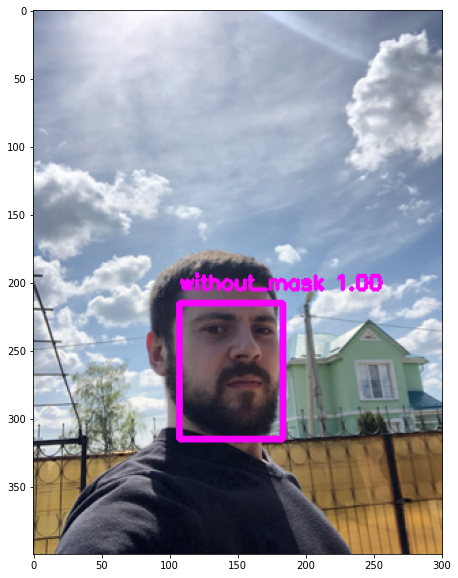

In [265]:
from random import choice

img = cv2.imread(choice(list_of_images))

net = cv2.dnn.readNetFromDarknet(
    '/content/darknet/build/darknet/x64/yolov4-tiny_masks.cfg',
    '/content/darknet/build/darknet/x64/backup/yolov4-tiny_masks_final.weights',
)

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)
class_names = []
with open('/content/darknet/build/darknet/x64/data/masks.names', 'r') as f:
    class_names = f.read().splitlines()

model = cv2.dnn_DetectionModel(net)
model.setInputParams(size=(416, 416), scale=1 / 255., swapRB=True)

classes, scores, boxes = model.detect(img, 0.2, 0.5)

for (classid, score, box) in zip(classes, scores, boxes):

    color = (255, 0, 250)#COLORS[int(classid) % len(COLORS)]
    label = f'{class_names[classid]} {score:.2f}' 
    print(box)
    cv2.rectangle(img, box, color, 4)
    cv2.putText(img, label, (box[0], box[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(10, 10))
plt.imshow(img[:,:,::-1])

In [266]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


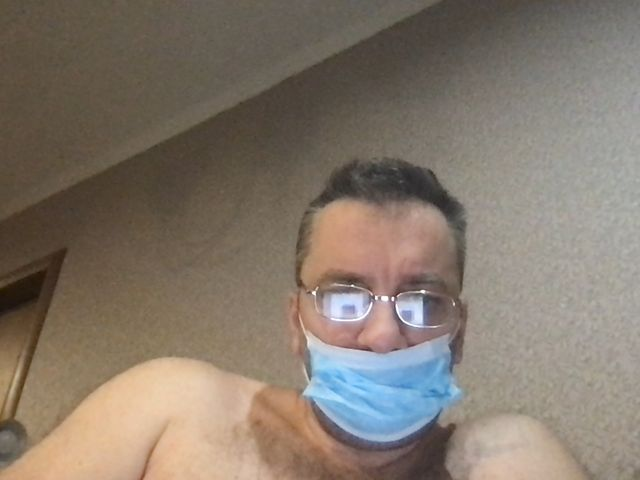

In [280]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Изображение сохранилось под именем `photo.jpg`. Теперь мы его можем открыть при помощи opencv и посмотреть на него уже из python-кода.

In [281]:
 import cv2
 import matplotlib.pyplot as plt


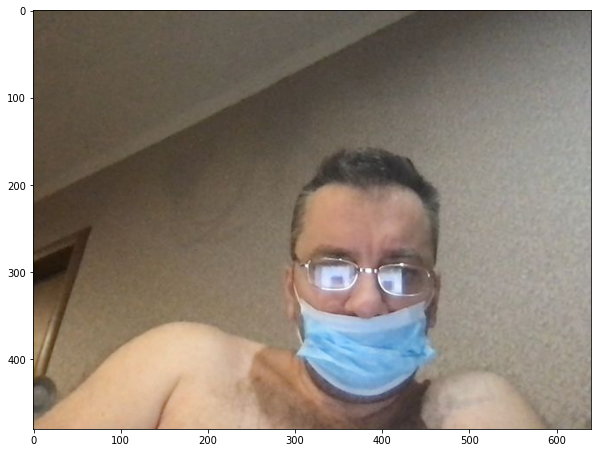

In [282]:
PATH_TO_SAVED_IMAGE = './photo.jpg'

image = cv2.imread(PATH_TO_SAVED_IMAGE)
image = image[:,:,::-1]

plt.figure(figsize=(10, 10))
plt.imshow(image)

На изображении выше представлен хитрый лис, но в вашем случае там будете сидеть вы. Если у вас нет веб-камеры или вы стесняетесь фотографировать себя, то можно скачать картинку из интернета или использовать любую из тестового набора данных (ни в коем случае не из тренировочного).

Далее надо сделать следующее: примените детектор к изображению. Он должен найти на нем bounding box определенного класса. Нас интересуют только лица с масками и без масок. После того, как бокс найден давайте заменим лицо внутри него на соответствующее эмодзи. Я скачал парочку из интернета: эмодзи с маской на лице и без нее.

Выполним код снизу, он загрузит два изображения эмодзи.

In [300]:
!gdown "https://drive.google.com/uc?export=download&id=1TGKGK78czrPWNWcxNOYaLbaFGTuelpfs"
!gdown "https://drive.google.com/uc?export=download&id=14hmxOrKEf-nC0o7SK2bgo5cjNOv_3mDZ"
!gdown -O './mask_weared_incorrect.png' 'https://www.pngrepo.com/png/58051/512/bad-emoticon-square-face.png'

Downloading...
From: https://drive.google.com/uc?export=download&id=1TGKGK78czrPWNWcxNOYaLbaFGTuelpfs
To: /content/darknet/mask.png
100% 43.5k/43.5k [00:00<00:00, 40.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=14hmxOrKEf-nC0o7SK2bgo5cjNOv_3mDZ
To: /content/darknet/without_mask.png
100% 1.57M/1.57M [00:00<00:00, 52.7MB/s]
Downloading...
From: https://www.pngrepo.com/png/58051/512/bad-emoticon-square-face.png
To: /content/darknet/mask_weared_incorrect.png
12.1kB [00:00, 19.6MB/s]


В папке content появились два изображения: `mask.png` и `without_mask.png`.

Теперь давайте представим, что у меня уже есть детекция мордочки хитрого лиса (я просто сам выбрал координаты), и моделька решила, что он без маски. Код ниже позволяет отобразить эмодзи без маски на изображении.

mask_weared_incorrect


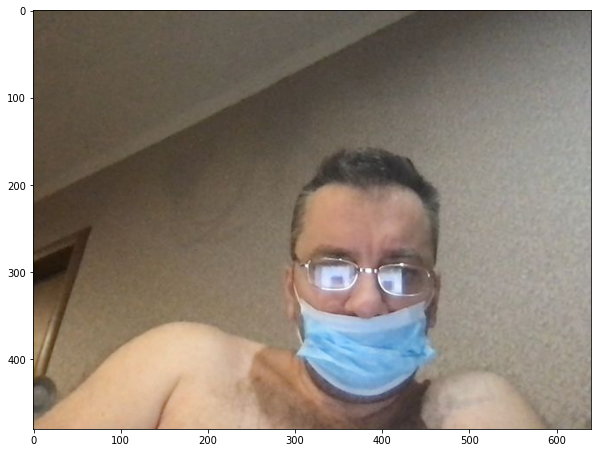

In [301]:
# определим пути к изображениям
PATH_TO_SAVED_IMAGE = './photo.jpg'
PATH_TO_IMAGE_WITH_MASK = './mask.png'
PATH_TO_IMAGE_WITHOUT_MASK = './without_mask.png'
PATH_TO_IMAGE_INCORRECT =  './mask_weared_incorrect.png'

# считываем изображения и сразу меняем BGR -> RGB
image = cv2.imread(PATH_TO_SAVED_IMAGE)[:,:,::-1]
emoji_mask = cv2.imread(PATH_TO_IMAGE_WITH_MASK)[:,:,::-1]
emoji_without_mask = cv2.imread(PATH_TO_IMAGE_WITHOUT_MASK)[:,:,::-1]
mask_weared_incorrect = cv2.imread(PATH_TO_IMAGE_INCORRECT)[:,:,::-1]


net = cv2.dnn.readNetFromDarknet(
    '/content/darknet/build/darknet/x64/yolov4-tiny_masks.cfg',
    '/content/darknet/build/darknet/x64/backup/yolov4-tiny_masks_final.weights',
)

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)
class_names = []
with open('/content/darknet/build/darknet/x64/data/masks.names', 'r') as f:
    class_names = f.read().splitlines()

model = cv2.dnn_DetectionModel(net)
model.setInputParams(size=(416, 416), scale=1 / 255., swapRB=False)

classes, scores, boxes = model.detect(image, 0.2, 0.5)


image_to_draw = image.copy()

for (classid, score, box) in zip(classes, scores, boxes):
  label = class_names[classid]
  print(label)
  face_crop = image_to_draw[box[1]: box[1] + box[3], box[0]: box[0] + box[2]]
  # отрисовываем эмодзи
  if label == 'without_mask':
    emoji = emoji_without_mask
  elif label == 'with_mask':
    emoji = emoji_mask
  else:
    emoji = mask_weared_incorrect
  emojy_to_draw = cv2.resize(emoji, (box[2], box[3]))
  face_crop[emojy_to_draw != 0] = emojy_to_draw[emojy_to_draw != 0]
# Отрисовываем изображение
plt.figure(figsize=(10, 10))
plt.imshow(image_to_draw)